In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
bench = 'fast'
minN = 1
maxN = 21

In [7]:
def readTimingsFile(num, base):
    res = []
    file = open('./data/' + base + '/' + str(num) + '/operator-timings-filtered.txt', encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([num, str(splitLine[1]), int(splitLine[2]), int(splitLine[3])])
    return res

results = []
for i in range(minN, maxN):
    results.append(readTimingsFile(i, bench))

In [8]:
eventMap = {
    "markedNext": "Marked as next",
    "phaseOutCompleted": "Fully phased out",
    "activeObjectsCreated": "All objects created",
    "markedActive": "Marked as active"
}
events = [f"Revision {x[2]}: {eventMap[x[1]]}" for x in results[0]]
timings = []
for i in range(len(results)):
    timings.append([x[3] for x in results[i]])

In [9]:
def getUserUpgradeTiming(num, base):
    file = open('./data/' + base + '/' + str(num) + '/user-timings.txt', encoding="utf8").read()
    return int(file.split('\n')[0])

for i in range(minN, maxN):
    timings[i - 1][0] = getUserUpgradeTiming(i, bench)

events[0] = "Upgrade Requested"

In [10]:
print(timings)

[[1638738863535, 1638738864477684540, 1638738869508023489, 1638738869643044775, 1638738869684141392], [1638739118669, 1638739119562499033, 1638739124582016308, 1638739124672588753, 1638739124714113367], [1638739355707, 1638739356672991975, 1638739361691735533, 1638739361757215276, 1638739361897477697], [1638739594899, 1638739595735609919, 1638739600755360189, 1638739600924813157, 1638739600928844501], [1639149985733, 1639149987021690057, 1639149987391964282, 1639149987758690535, 1639149988027700519], [1638740075675, 1638740076584132396, 1638740081602894120, 1638740081767421444, 1638740081767942542], [1638740319029, 1638740319893726427, 1638740324913391438, 1638740325026590489, 1638740325058582150], [1638740565307, 1638740566228427191, 1638740571248834243, 1638740571301539600, 1638740571422467298], [1638740766643, 1638740767404982524, 1638740772424898152, 1638740772510839383, 1638740772553164964], [1638740990371, 1638740991288313614, 1638740996310290569, 1638740996463862249, 16387409964

In [11]:
initNanos = []
for i in range(len(timings)):
    initNano = timings[i][0] * (10 ** 6)
    initNanos.append(initNano)
    timings[i][0] = 0
    for j in range(1, len(timings[i])):
        timings[i][j] = (timings[i][j] - initNano) / (10 ** 9)

In [12]:
print(timings)

[[0, 0.94268454, 5.973023489, 6.108044775, 6.149141392], [0, 0.893499033, 5.913016308, 6.003588753, 6.045113367], [0, 0.965991975, 5.984735533, 6.050215276, 6.190477697], [0, 0.836609919, 5.856360189, 6.025813157, 6.029844501], [0, 1.288690057, 1.658964282, 2.025690535, 2.294700519], [0, 0.909132396, 5.92789412, 6.092421444, 6.092942542], [0, 0.864726427, 5.884391438, 5.997590489, 6.02958215], [0, 0.921427191, 5.941834243, 5.9945396, 6.115467298], [0, 0.761982524, 5.781898152, 5.867839383, 5.910164964], [0, 0.917313614, 5.939290569, 6.092862249, 6.109834472], [0, 0.813448942, 5.831968377, 6.155248659, 6.159034396], [0, 0.936077644, 5.955017378, 6.160053856, 6.3455504], [0, 1.276397197, 6.31631841, 6.538001276, 6.556428393], [0, 1.30930384, 6.327443962, 6.412294318, 6.523942486], [0, 1.00160197, 6.064697733, 6.229353278, 6.232266625], [0, 0.905118892, 5.924453212, 6.096595964, 6.115232694], [0, 0.831906002, 5.853164545, 6.007872587, 6.049488024], [0, 0.903727976, 5.922350491, 6.11129879

In [13]:
from statistics import mean

avgTimings = [float(sum(col))/len(col) for col in zip(*timings)]

In [14]:
print(avgTimings)

[0.0, 0.9686361211500001, 5.7593780398500005, 5.92087082155, 5.9856840841]


In [16]:
def getMessageTimings(num, base):
    file = open('./data/' + base + '/' + str(num) + '/message-timings.txt', encoding="utf8").read()
    res = []
    for ind, line in enumerate(file.split('\n')):
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([int(splitLine[0]), int(splitLine[3])])
    return res


In [18]:
import sys
import math
# Find line segment x-values
# Blue -> Rev 1
# Orange -> both processing
# Red -> No revision processing
# Green -> Rev 2 processing
def findExtremes(revNum, userTimings):
    minEnd = sys.maxsize
    maxEnd = ~sys.maxsize
    for entry in userTimings:
        if entry[0] != revNum:
            continue
        minEnd = min(minEnd, entry[1])
        maxEnd = max(maxEnd, entry[1])
    return minEnd, maxEnd


def toSecondsFromBegin(timeNano, beginNano):
    return (timeNano - beginNano) / (10 ** 9)

revProcessingTransTimings = []
for i in range(minN, maxN):
    userTimings = getMessageTimings(i, bench)
    first1, last1 = findExtremes(1, userTimings)
    first2, last2 = findExtremes(2, userTimings)

    first1 = 0 # fit to graph
    # convert to seconds from begin
    initNano = initNanos[i - 1]
    last1 = toSecondsFromBegin(last1, initNano) 
    first2 = toSecondsFromBegin(first2, initNano)
    last2 = toSecondsFromBegin(last2, initNano)
    revProcessingTransTimings.append([first1, last1, first2, last2])


In [19]:
print(revProcessingTransTimings)

[[0, 1.030411778, 15.315399862, 60.942909674], [0, 1.149600344, 14.856783584, 61.112685787], [0, 1.135085957, 14.904390925, 61.09140009], [0, 0.997581981, 14.668869811, 65.56121948], [0, 1.476054391, 13.410901338, 65.674690189], [0, 1.050986134, 14.59859141, 61.044775807], [0, 1.058785706, 14.947436054, 61.884045696], [0, 1.7434522, 15.760446787, 61.726301634], [0, 1.000273613, 15.132574567, 61.319254221], [0, 1.155448368, 16.387487196, 61.09829941], [0, 1.724474311, 14.608874152, 60.930939974], [0, 1.248877541, 16.125694314, 67.225831133], [0, 1.38864547, 16.286251895, 61.616720254], [0, 1.518898264, 16.38752712, 61.450949586], [0, 1.191845627, 16.024995519, 61.209268618], [0, 1.110894175, 15.961213398, 61.051605318], [0, 1.129942775, 15.228378623, 60.927372371], [0, 1.310023409, 15.589165692, 60.995131747], [0, 1.391295998, 15.375493685, 61.243273591], [0, 1.866883212, 14.92775906, 61.061051035]]


In [20]:
avgProcessingTransTimings = [float(sum(col))/len(col) for col in zip(*revProcessingTransTimings)]

In [21]:
print(avgProcessingTransTimings)

[0.0, 1.2839730627, 15.3249117496, 61.95838628074999]


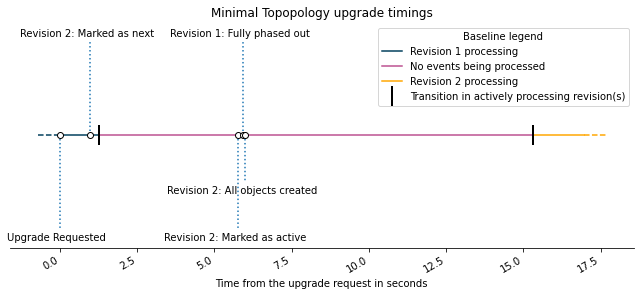

In [27]:
levels = np.tile([-0.5, 0.5, -0.5, 0.5, -0.25, 0.5],
                 int(np.ceil(len(events)/6)))[:len(events)]

fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Minimal Topopology upgrade timings")

markerline, stemline, baseline = ax.stem(avgTimings, levels,
                                         linefmt=":", basefmt="k-", 
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(avgTimings)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(avgTimings, levels, events, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="center")


plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

baseline.set_visible(False)
baseY = baseline.get_ydata()[0]
baseYs = [baseY, baseY]
xRev1 = [0, avgProcessingTransTimings[1]]
xNone = [avgProcessingTransTimings[1], avgProcessingTransTimings[2]]
xRev2 = [avgProcessingTransTimings[2], avgProcessingTransTimings[3] - 45]

# add colored baselines
pFirst = plt.plot(xRev1, baseYs, '#003f5c', label="Revision 1 processing")
plt.plot(xNone, baseYs, '#bc5090', label="No events being processed")
pLast = plt.plot(xRev2, baseYs, '#ffa600', label="Revision 2 processing")
# add ends of baseline
plt.plot([-0.7, 0], baseYs, '--', color=pFirst[0].get_color())
plt.plot([xRev2[1], xRev2[1] + 0.7], baseYs, '--', color=pLast[0].get_color())

# plot transition markers
plt.plot([avgProcessingTransTimings[1]], [baseY], marker="|", color='white', markersize=20, markeredgecolor='black', mew=2, label='Transition in actively processing revision(s)')
plt.plot([avgProcessingTransTimings[2]], [baseY], marker="|", color='white', markersize=20, markeredgecolor='black', mew=2)

plt.legend(loc="upper right", title="Baseline legend")
plt.xlabel("Time from the upgrade request in seconds")
ax.margins(y=0.1)
plt.show()

In [23]:
def readDetailedMessageTimings(base, num):
    res = []
    file = open('./data/' + base + '/' + str(num) + '/message-timings.txt', encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([num, int(splitLine[0]), int(splitLine[1]), int(splitLine[2]), int(splitLine[3]), float(splitLine[4])])
    return res

messTimingsDetailed = []
for i in range(1, 21):
    messTimingsDetailed = messTimingsDetailed + readDetailedMessageTimings('fast', i)

In [24]:
import pandas as pd
df = pd.DataFrame(messTimingsDetailed, columns=['benchNum', 'version', 'id', 'beginTime', 'endTime', 'latency'])

In [25]:
firstMsgLatencies = []
df_filtered = []
for i in range(1, 21):
    # ensure no duplicates and no lost message (i.e. checking for duplicate IDs, missing IDs)
    df_bench = df[df['benchNum'] == i].reset_index()
    msg_ids = df_bench['id']
    msg_ids = msg_ids.sort_values(ascending=True).values
    for j in range(1, len(msg_ids)):
        if msg_ids[j] == msg_ids[j - 1]:
            print("DUPLICATE FOUND")
        elif msg_ids[j] > (msg_ids[j-1] + 1):
            print("MESSAGE(s) LOST")